In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/custom_data/'
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
import pandas as pd
ori_export = pd.read_csv(path+'exports.csv')
ori_umcsent = pd.read_csv(path+'UMCSENT.csv', skiprows= 10 ,dtype = {'observation_date':str,'UMCSENT':float})
ori_epu = pd.read_csv(path+'EPU.csv')

In [ ]:
for i in ori_export.columns:
  if i != '기간':
    ori_export[i] = pd.to_numeric(ori_export[i].str.replace(pat=r'[^A-Za-z0-9]', repl= '', regex=True),downcast='float')

In [ ]:
f1 = ori_epu['Three_Component_Index'][180:430]
f1.index = np.arange(0,250)
trn_y = ori_export['수출금액'][1:251]
trn_y.index = np.arange(0,250)
DATA = pd.concat([ori_umcsent['UMCSENT'][:250],f1,trn_y],axis=1,ignore_index=True)
DATA.index = ori_export['기간'][1:251]

In [ ]:
def scaling(x):
  min_max_scaler = MinMaxScaler()
  df = x.copy()
  fitted = min_max_scaler.fit(x)
  output = min_max_scaler.transform(x)
  output = pd.DataFrame(output, columns=df.columns, index=list(df.index.values))
  return output

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X = scaling(DATA)
X.describe()

,0,1,2
count,250.000000,250.000000,250.000000
mean,0.534998,0.215624,0.526546
std,0.215383,0.152158,0.294877
min,0.000000,0.000000,0.000000
25%,0.369489,0.111933,0.273633
50%,0.582892,0.179071,0.603650
75%,0.694885,0.284004,0.792516
max,1.000000,1.000000,1.000000


In [ ]:
def create_time_steps(length):
  return list(range(-length,0))

In [ ]:
def multivariate_data(dataset,target,start_index,end_index,history_size,target_size,
                      step,single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset)-target_size
  
  for i in range(start_index,end_index):
    indices = range(i-history_size,i,step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
      
  return np.array(data),np.array(labels)

In [ ]:
def plot_train_history(history,title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()
  plt.plot(epochs,loss,'b',label='Training loss')
  plt.title(title)
  plt.legend()
  plt.show()

In [ ]:
dataset = X.values

In [ ]:
future_target = 5
past_history = 5
step = 1

x_train,y_train = multivariate_data(dataset,dataset[:,2],0,125,
                                  past_history,
                                  future_target,step)
x_val,y_val = multivariate_data(dataset,dataset[:,2],125,150,
                                  past_history,
                                  future_target,step)

In [ ]:
import tensorflow as tf

buffer_size = 95
batch_size = 16
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_data_multi = val_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

In [ ]:
def multi_step_plot(history,true_future,prediction):
  plt.figure(figsize=(12,6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in,np.array(history[:,2]), label = 'history')
  plt.plot(np.arange(num_out)/step,np.array(true_future),'bo',label='True future')

  if prediction.any():
    plt.plot(np.arange(num_out)/step,np.array(prediction),'ro',label='predicted future')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
import tensorflow as tf

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.GRU(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.GRU(16,activation='relu',return_sequences=True))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.GRU(16,activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(5))

multi_step_model.compile(optimizer='adam',loss='mse')
multi_step_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_20 (GRU)                 (None, 5, 32)             3552      
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
gru_21 (GRU)                 (None, 5, 16)             2400      
_________________________________________________________________
dropout_11 (Dropout)         (None, 5, 16)             0         
_________________________________________________________________
gru_22 (GRU)                 (None, 16)                1632      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 85        
Total params: 7,669
Trainable params: 7,669
Non-trainable params: 0
___________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,mode='auto')
multi_step_history = multi_step_model.fit(train_data_multi,epochs=10,
                                          steps_per_epoch=10,
                                          validation_steps=50,
                                          validation_data=val_data_multi,
                                          verbose=0,callbacks=[callback],shuffle=True)

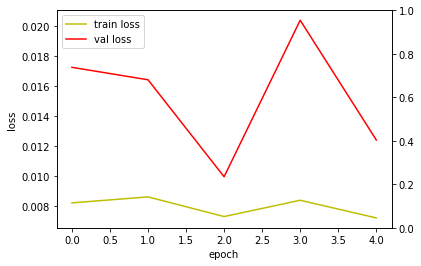

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(multi_step_history.history['loss'], 'y', label='train loss')
loss_ax.plot(multi_step_history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

#acc_ax.plot(hist.history['mae'], 'b', label='train mae')
#acc_ax.plot(hist.history['val_mae'], 'g', label='val mae')
#acc_ax.set_ylabel('mae')
#acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
x_test,y_test = multivariate_data(dataset,dataset[:,2],145,250,
                                  past_history,
                                  future_target,step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
y_pred = []
for i in range(20):
  data = x_test[5*i].reshape(1,5,3)
  y_pred.append(multi_step_model.predict(data))

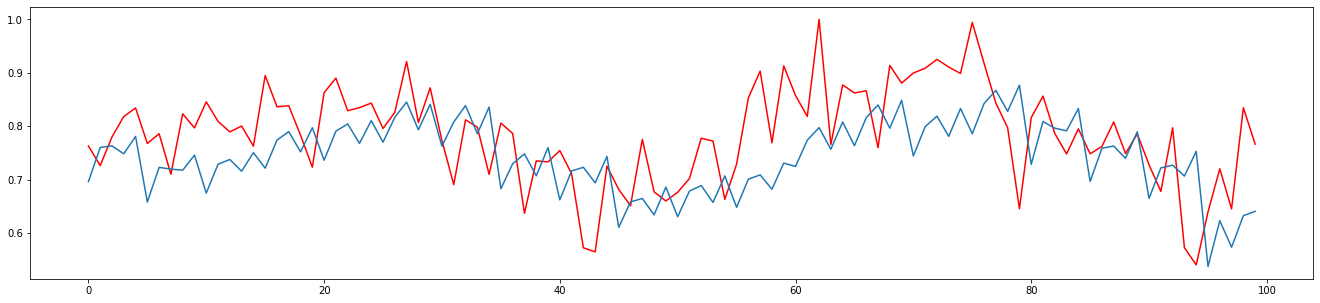

In [ ]:
y_ = np.array(y_pred).flatten()
R_y = X[2].values[-100:]
days = np.arange(100)
plt.figure(figsize=(23,5))
plt.plot(days,R_y,'r',days,y_)

In [ ]:
np.savetxt(path+'GRU.txt', y_, fmt='%.6f', delimiter=',')

#GRU 앙상블 러닝

In [ ]:
from tensorflow.keras import layers
def build_model(layer_n,feature_n,act_f='relu'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.GRU(feature_n,activation=act_f,return_sequences=True,
                         input_shape=x_train.shape[-2:]))
  model.add(tf.keras.layers.Dropout(0.2))
  for i in range(layer_n):
    model.add(layers.GRU(feature_n,activation=act_f,return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
  model.add(layers.GRU(feature_n,activation=act_f))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(layers.Dense(5))
  model.compile(optimizer='adam',loss='mse',metrics=['mae'])
  return model

In [ ]:
future_target=5
past_history=5
step=1
import tensorflow as tf

x_train,y_train = multivariate_data(dataset,dataset[:,2],0,125,
                                        past_history,future_target,step)
x_val,y_val = multivariate_data(dataset,dataset[:,2],125,150,
                                    past_history,future_target,step)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data_multi = train_data_multi.cache().shuffle(125).batch(16).repeat()
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_data_multi = val_data_multi.cache().shuffle(25).batch(8).repeat()

In [ ]:
x_test,y_test = multivariate_data(dataset,dataset[:,2],145,250,
                                  past_history,
                                  future_target,step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
tree_n = 50

all_predicts = []
all_layer = []
all_feature = []
all_epoch = []
all_mse = []
all_mae = []
all_val_mse = []
all_val_mae = []
all_steps_per_epoch = []
all_validation_steps = []
for i in range(tree_n):
  print('tree_n :',i+1)
  layer = np.random.randint(0, high=3, size=None, dtype=int)
  feature = np.random.randint(32, high=64, size=None, dtype=int)
  epoch_n = np.random.randint(15, high=25, size=None, dtype=int)
  step_n = np.random.randint(5, high=8, size=None, dtype=int)
  val_n = np.random.randint(15, high=30, size=None, dtype=int)
  all_layer.append(layer)
  all_feature.append(feature)
  all_epoch.append(epoch_n)
  all_steps_per_epoch.append(step_n)
  all_validation_steps.append(val_n)
  result_tst = []

  model = build_model(layer_n=layer,feature_n=feature,act_f='relu')
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,mode='auto')
  hist_model = model.fit(train_data_multi,epochs=epoch_n,
                           steps_per_epoch=step_n,
                           validation_steps=val_n,
                           validation_data = val_data_multi,
                           callbacks = [callback],verbose=0,shuffle=True)
  for j in range(20):
    data = x_test[5*j].reshape(1,5,3)
    result_tst.append(model.predict(data))

  all_predicts.append(result_tst)
  all_mse.append(hist_model.history['loss'])
  all_mae.append(hist_model.history['mae'])
  all_val_mse.append(hist_model.history['val_loss'])
  all_val_mae.append(hist_model.history['val_mae'])

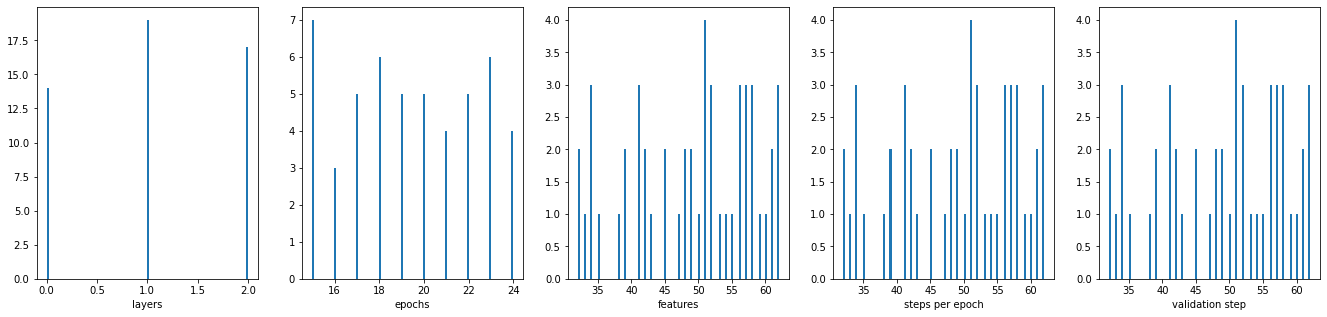

In [ ]:
df1 = all_layer.copy()
df2 = all_epoch.copy()
df3 = all_feature.copy()
df4 = all_steps_per_epoch.copy()
df5 = all_validation_steps.copy()

plt.figure(figsize=(23,5))
plt.subplot(1,5,1)
plt.hist(df1,bins=100)
plt.xlabel('layers')

plt.subplot(1,5,2)
plt.hist(df2,bins=100)
plt.xlabel('epochs')

plt.subplot(1,5,3)
plt.hist(df3,bins=100)
plt.xlabel('features')

plt.subplot(1,5,4)
plt.hist(df3,bins=100)
plt.xlabel('steps per epoch')

plt.subplot(1,5,5)
plt.hist(df3,bins=100)
plt.xlabel('validation step')

plt.show()

In [ ]:
all_predicts = np.array(all_predicts)
all_layer = np.array(all_layer)
all_feature = np.array(all_feature)
all_epoch = np.array(all_epoch)
all_mse = np.array(all_mse)
all_mae = np.array(all_mae)
all_val_mse = np.array(all_val_mse)
all_val_mae = np.array(all_val_mae)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  im

In [ ]:
from scipy.stats import t

sample = all_predicts.copy()
sample = sample.reshape(tree_n,-1)
sample_mean = sample.mean(axis=0)
sample_std = sample.std(axis=0)

df = tree_n-1
t_ = t(df)
t_05 = t_.ppf(0.95)
L_= sample_mean - t_05*(sample_std/np.sqrt(tree_n))
U_= sample_mean + t_05*(sample_std/np.sqrt(tree_n))

df = tree_n-1
t_ = t(df)
t_10 = t_.ppf(0.90)
L__= sample_mean - t_05*(sample_std/np.sqrt(tree_n))
U__= sample_mean + t_05*(sample_std/np.sqrt(tree_n))

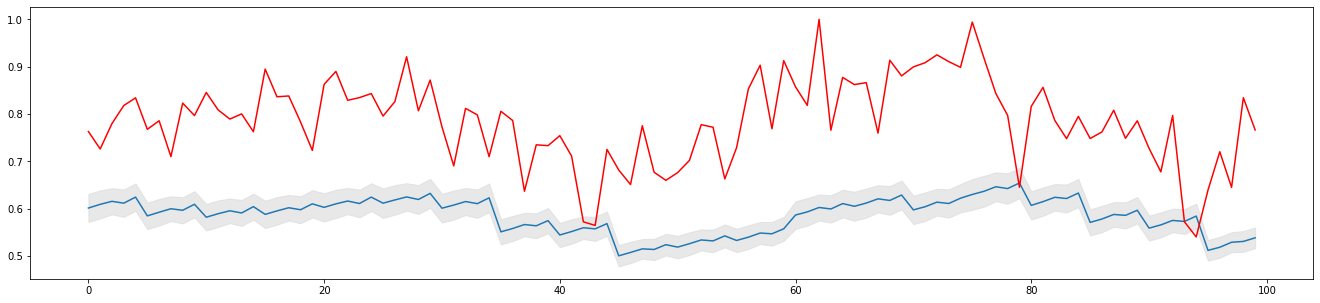

In [ ]:
L = L_.copy()
U = U_.copy()
L2 = L__.copy()
U2 = U__.copy()
sample_ = sample.copy()
sample_ = sample_.T

MU = sample_mean.copy()

days = np.arange(100)
asw_y = X.values[-100:]
plt.figure(figsize=(23,5))
plt.plot(days,MU,days,asw_y[:,2],'r-')
#plt.fill_between(days, L, U, color='green', alpha=0.5)
plt.fill_between(days, L2, U2, color='lightgray', alpha=0.5)
plt.show()

0.05781771242618561 12
1 19 54 5 29


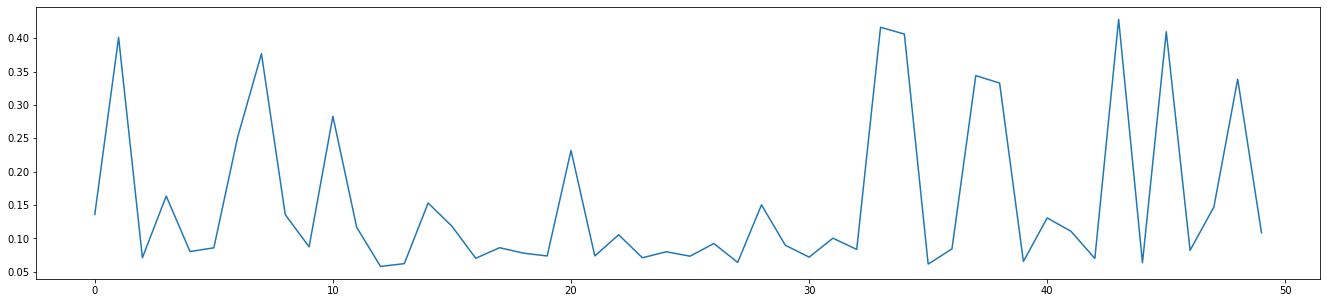

In [ ]:
dv = all_val_mae.copy()
gg = []
for i in range(tree_n):
  dd = np.array(dv[i]).min()
  gg.append(dd)

plt.figure(figsize=(23,5))
plt.plot(gg)

aa = min(gg)
bb = gg.index(aa)

print(aa,bb)

print(all_layer[bb],all_epoch[bb],all_feature[bb],all_steps_per_epoch[bb],all_validation_steps[bb])

0.12392586641586743 30
1 23 58 7 20


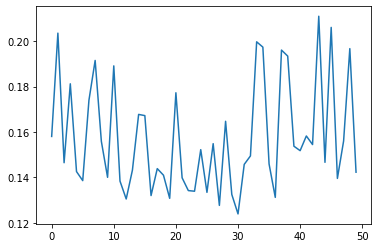

In [ ]:
dv = all_mae.copy()
gg = []
for i in range(tree_n):
  dd = np.array(dv[i]).mean()
  gg.append(dd)

plt.plot(gg)

aa = min(gg)
bb = gg.index(aa)

print(aa,bb)

print(all_layer[bb],all_epoch[bb],all_feature[bb],all_steps_per_epoch[bb],all_validation_steps[bb])

#최적 파라미터 실험실

In [ ]:
model = build_model(1,60)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,mode='auto')
hist_model = model.fit(train_data_multi,epochs=23,
                           steps_per_epoch=7,
                           validation_steps=20,
                           validation_data = val_data_multi,
                           callbacks = [callback],verbose=0,shuffle=True)

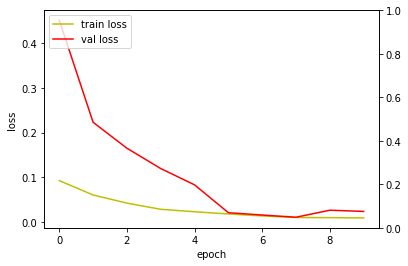

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_model.history['loss'], 'y', label='train loss')
loss_ax.plot(hist_model.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

#acc_ax.plot(hist.history['mae'], 'b', label='train mae')
#acc_ax.plot(hist.history['val_mae'], 'g', label='val mae')
#acc_ax.set_ylabel('mae')
#acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
y_pred = []
for i in range(20):
  data = x_test[5*i].reshape(1,5,3)
  y_pred.append(model.predict(data))

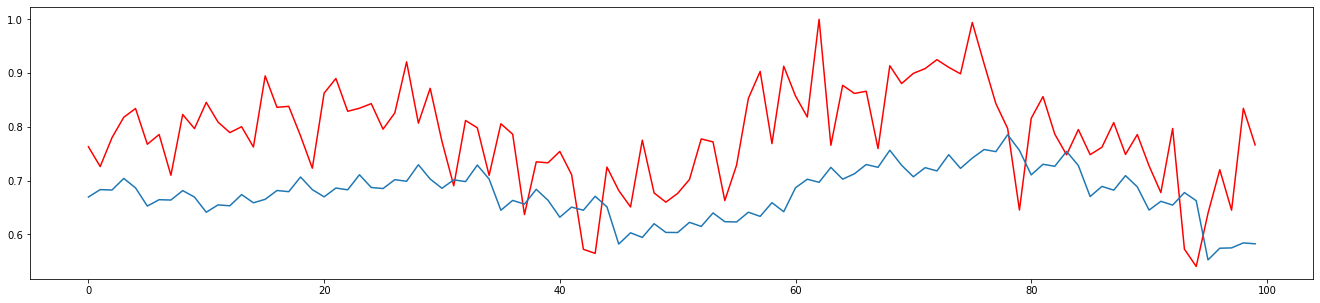

In [ ]:
y_ = np.array(y_pred).flatten()
R_y = X[2].values[-100:]
days = np.arange(100)
plt.figure(figsize=(23,5))
plt.plot(days,R_y,'r',days,y_)